# NLP Topic Modeling: Obama VS Trump (Round II)

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

https://radimrehurek.com/gensim/models/ldamodel.html

### Import packages

In [1]:
# ! pip install gensim

In [2]:
import pandas as pd
import numpy as np # np.random.seed(2018)
import re
from pprint import pprint

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
# nltk.download('wordnet')

unable to import 'smart_open.gcs', disabling that module


### Import data

In [3]:
# https://www.kaggle.com/austinreese/trump-tweets
df_trump = pd.read_csv('./datasets/trump_tweets.csv')
# https://www.kaggle.com/datacrux/barack-obama-twitterdata-from-20122019
df_obama = pd.read_csv('./datasets/obama_tweets.csv')

### Explore data

In [4]:
df_trump.head(1)

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,NaN,NaN,NaN


In [5]:
df_obama.head(1)

,Date,Username,Tweet-text,Tweet Link,Retweets,Likes,TweetImageUrl,Image
0,2019/04/10_17:08,https://twitter.com/BarackObama,From a big NBA fan congrats to future Hall of ...,https://twitter.com/BarackObama/status/1116130...,20954,175133,NaN,NaN


### Data preprocessing

#### Deleting links

In [6]:
# pic.twitter.com
df_trump['content'] = df_trump['content'].map(lambda x: re.sub('pic.twitter.com/\w\w\w\w\w\w\w\w\w\w', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub('pic.twitter.com/\w\w\w\w\w\w\w\w\w\w', '', x))

In [7]:
# tinyurl
df_trump['content'] = df_trump['content'].map(lambda x: re.sub('http://tinyurl.com/\w\w\w\w\w\w', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub('http://tinyurl.com/\w\w\w\w\w\w', '', x))

In [8]:
# bit.ly
df_trump['content'] = df_trump['content'].map(lambda x: re.sub('http://bit.ly/\w\w\w\w\w\w', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub('http://bit.ly/\w\w\w\w\w\w', '', x))

In [9]:
# Others:
df_trump['content'] = df_trump['content'].map(lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))

#### Delete 'Donald', 'Trump', 'Barack', 'Obama', 'President'

In [10]:
df_trump['content'] = df_trump['content'].map(lambda x: re.sub('President', '', x))
df_trump['content'] = df_trump['content'].map(lambda x: re.sub('Donald', '', x))
df_trump['content'] = df_trump['content'].map(lambda x: re.sub('Trump', '', x))

In [11]:
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub('President', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub('Barack', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub('Obama', '', x))

#### Next, we will perform the following steps:

- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All stopwords are removed.
- Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
- Words are stemmed — words are reduced to their root form.

In [12]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [13]:
# Select a document to preview after preprocessing.
doc_sample = df_trump['content'][0]
print('Original document:')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('Tokenized and lemmatized document:')
print(preprocess(doc_sample))

Original document:
['Be', 'sure', 'to', 'tune', 'in', 'and', 'watch', '', '', 'on', 'Late', 'Night', 'with', 'David', 'Letterman', 'as', 'he', 'presents', 'the', 'Top', 'Ten', 'List', 'tonight!']
Tokenized and lemmatized document:
['sure', 'tune', 'watch', 'late', 'night', 'david', 'letterman', 'present', 'list', 'tonight']


In [14]:
# Preprocess the tweets, saving the results as ‘processed_tweets’
processed_tweets_trump = df_trump['content'].map(preprocess)
print(processed_tweets_trump[:10])

processed_tweets_obama = df_obama['Tweet-text'].map(preprocess)
print(processed_tweets_obama[:10])

0    [sure, tune, watch, late, night, david, letter...
1    [appear, view, tomorrow, morn, discuss, celebr...
2    [read, financi, tip, late, david, letterman, f...
3    [blog, post, celebr, apprentic, final, lesson,...
4              [persona, wallflow, build, wall, cling]
5    [miss, tara, conner, fire, believ, second, cha...
6    [listen, interview, discuss, book, think, like...
7                [strive, whole, sens, wonder, intact]
8    [enter, think, like, champion, sign, book, key...
9                     [achiev, achiev, plateau, begin]
Name: content, dtype: object
0    [congrat, futur, hall, famer, dwyan, wade, dir...
1    [minut, take, stage, foundat, town, hall, euro...
2                              [voic, everybodi, hear]
3    [stori, peopl, good, worth, share, bradpaisley...
4    [great, chicago, histor, mayor, race, high, qu...
5    [valeri, oldest, friend, advisor, decid, offic...
6    [night, chanc, meet, term, democrat, congress,...
7    [nick, time, bracket, shin, mom

### WordCloud

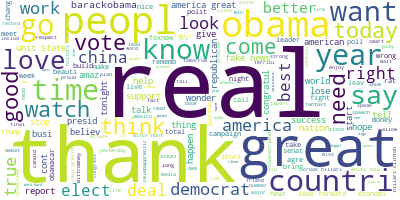

In [15]:
# Trump:

# Join the different processed tweets together
processed_tweets_trump_flat = [item for sublist in processed_tweets_trump for item in sublist]
trump_tweets = ','.join(list(processed_tweets_trump_flat))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(trump_tweets)

# Visualize the word cloud
wordcloud.to_image()

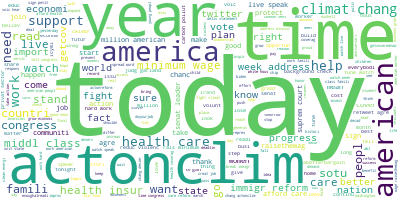

In [16]:
# Obama:

# Join the different processed tweets together
processed_tweets_obama_flat = [item for sublist in processed_tweets_obama for item in sublist]
obama_tweets = ','.join(list(processed_tweets_obama_flat))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(obama_tweets)

# Visualize the word cloud
wordcloud.to_image()

### Bag of Words on the Data set

Create a dictionary from ‘processed_tweets’ containing the number of times a word appears in the training set.

In [17]:
dictionary_trump = gensim.corpora.Dictionary(processed_tweets_trump)
dictionary_obama = gensim.corpora.Dictionary(processed_tweets_obama)

**Gensim filter_extremes**

Filter out tokens that appear in
- less than 15 tweets (absolute number)
- more than 0.5 tweets (fraction of total corpus size, not absolute number).

After the above two steps, keep only the first 100000 most frequent tokens.

In [18]:
dictionary_trump.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
dictionary_obama.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

**Gensim doc2bow**

For each tweet we create a dictionary reporting how many words and how many times those words appear. Save this to ‘bow_corpus’.

In [19]:
bow_corpus_trump = [dictionary_trump.doc2bow(tweet) for tweet in processed_tweets_trump]
bow_corpus_obama = [dictionary_obama.doc2bow(tweet) for tweet in processed_tweets_obama]

#### Preview Bag Of Words for our sample preprocessed tweet

In [20]:
bow_tweet_0 = bow_corpus_trump[0]

for i in range(len(bow_tweet_0)):
    print("Word {} (\"{}\") appears {} time.".format(bow_tweet_0[i][0],
                                                     dictionary_trump[bow_tweet_0[i][0]],
                                                     bow_tweet_0[i][1]))

Word 0 ("david") appears 1 time.
Word 1 ("late") appears 1 time.
Word 2 ("letterman") appears 1 time.
Word 3 ("list") appears 1 time.
Word 4 ("night") appears 1 time.
Word 5 ("present") appears 1 time.
Word 6 ("sure") appears 1 time.
Word 7 ("tonight") appears 1 time.
Word 8 ("tune") appears 1 time.
Word 9 ("watch") appears 1 time.


### TF-IDF

Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first tweet.

In [21]:
tfidf_trump = models.TfidfModel(bow_corpus_trump)
corpus_tfidf_trump = tfidf_trump[bow_corpus_trump]

tfidf_obama = models.TfidfModel(bow_corpus_obama)
corpus_tfidf_obama = tfidf_obama[bow_corpus_obama]

for doc in corpus_tfidf_trump:
    pprint(doc)
    break

[(0, 0.3495817236240656),
 (1, 0.34718510839012195),
 (2, 0.37110457950619735),
 (3, 0.3614345389996703),
 (4, 0.24279865503814307),
 (5, 0.36904219170145297),
 (6, 0.29535621268667295),
 (7, 0.23711123196556383),
 (8, 0.3227975642141983),
 (9, 0.214716002673731)]


### Running LDA using Bag of Words

Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [22]:
lda_model_trump = gensim.models.LdaMulticore(bow_corpus_trump, num_topics=5, 
                                             id2word=dictionary_trump, passes=2, workers=2)

In [23]:
lda_model_obama = gensim.models.LdaMulticore(bow_corpus_obama, num_topics=5, 
                                             id2word=dictionary_obama, passes=2, workers=2)

For each topic, we will explore the words occuring in that topic and its relative weight.

In [24]:
for idx, topic in lda_model_trump.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.021*"democrat" + 0.018*"peopl" + 0.015*"countri" + 0.015*"want" + 0.013*"state" + 0.013*"fake" + 0.012*"border" + 0.009*"know" + 0.009*"deal" + 0.009*"republican"
Topic: 1 
Words: 0.016*"impeach" + 0.015*"great" + 0.012*"hillari" + 0.012*"vote" + 0.009*"thank" + 0.009*"republican" + 0.009*"news" + 0.008*"elect" + 0.008*"democrat" + 0.007*"poll"
Topic: 2 
Words: 0.050*"real" + 0.020*"great" + 0.019*"need" + 0.016*"vote" + 0.015*"thank" + 0.014*"presid" + 0.014*"america" + 0.013*"countri" + 0.013*"time" + 0.011*"true"
Topic: 3 
Words: 0.070*"great" + 0.033*"real" + 0.019*"thank" + 0.012*"hoax" + 0.011*"love" + 0.010*"good" + 0.010*"america" + 0.010*"peopl" + 0.009*"tonight" + 0.009*"night"
Topic: 4 
Words: 0.035*"thank" + 0.014*"hunt" + 0.014*"look" + 0.013*"report" + 0.013*"great" + 0.012*"think" + 0.012*"witch" + 0.010*"work" + 0.009*"real" + 0.009*"hous"


In [25]:
for idx, topic in lda_model_obama.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.043*"care" + 0.027*"american" + 0.025*"watch" + 0.021*"health" + 0.020*"week" + 0.019*"peopl" + 0.018*"address" + 0.016*"congress" + 0.016*"afford" + 0.013*"million"
Topic: 1 
Words: 0.023*"famili" + 0.023*"live" + 0.022*"time" + 0.018*"congress" + 0.018*"work" + 0.018*"american" + 0.017*"speak" + 0.015*"today" + 0.014*"middl" + 0.014*"year"
Topic: 2 
Words: 0.040*"chang" + 0.032*"climat" + 0.017*"america" + 0.016*"actonclim" + 0.016*"state" + 0.015*"american" + 0.013*"want" + 0.013*"today" + 0.012*"sotu" + 0.012*"work"
Topic: 3 
Words: 0.029*"congress" + 0.016*"need" + 0.015*"work" + 0.014*"twitter" + 0.014*"support" + 0.013*"read" + 0.013*"job" + 0.012*"american" + 0.012*"violenc" + 0.011*"plan"
Topic: 4 
Words: 0.031*"care" + 0.023*"health" + 0.020*"time" + 0.016*"immigr" + 0.016*"help" + 0.015*"american" + 0.013*"reform" + 0.013*"year" + 0.013*"stand" + 0.011*"need"


### Running LDA using TF-IDF

In [26]:
lda_model_tfidf_trump = gensim.models.LdaMulticore(corpus_tfidf_trump, num_topics=5,
                                             id2word=dictionary_trump, passes=2, workers=4)

lda_model_tfidf_obama = gensim.models.LdaMulticore(corpus_tfidf_obama, num_topics=5,
                                             id2word=dictionary_obama, passes=2, workers=4)

In [27]:
for idx, topic in lda_model_tfidf_trump.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.012*"real" + 0.012*"thank" + 0.011*"vote" + 0.008*"good" + 0.008*"hillari" + 0.007*"great" + 0.006*"crook" + 0.006*"clinton" + 0.005*"republican" + 0.005*"deal"
Topic: 1 Word: 0.052*"thank" + 0.027*"real" + 0.015*"great" + 0.014*"america" + 0.013*"presid" + 0.008*"love" + 0.007*"work" + 0.006*"impeach" + 0.006*"need" + 0.005*"countri"
Topic: 2 Word: 0.017*"great" + 0.013*"real" + 0.006*"thank" + 0.006*"fake" + 0.006*"year" + 0.005*"look" + 0.005*"time" + 0.005*"think" + 0.005*"want" + 0.005*"job"
Topic: 3 Word: 0.010*"great" + 0.009*"true" + 0.008*"real" + 0.007*"interview" + 0.006*"tonight" + 0.005*"enjoy" + 0.005*"thank" + 0.005*"countri" + 0.005*"nation" + 0.005*"agre"
Topic: 4 Word: 0.007*"real" + 0.007*"great" + 0.006*"time" + 0.005*"peopl" + 0.005*"countri" + 0.005*"border" + 0.005*"democrat" + 0.004*"need" + 0.004*"year" + 0.004*"vote"


In [28]:
for idx, topic in lda_model_tfidf_obama.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.015*"senat" + 0.015*"today" + 0.011*"doyourjob" + 0.011*"year" + 0.010*"time" + 0.010*"american" + 0.009*"fair" + 0.009*"wage" + 0.009*"congress" + 0.008*"minimum"
Topic: 1 Word: 0.015*"america" + 0.013*"live" + 0.012*"american" + 0.012*"economi" + 0.011*"address" + 0.011*"watch" + 0.010*"week" + 0.010*"fact" + 0.009*"retweet" + 0.009*"progress"
Topic: 2 Word: 0.021*"care" + 0.018*"health" + 0.015*"time" + 0.012*"american" + 0.011*"work" + 0.010*"right" + 0.010*"year" + 0.009*"million" + 0.009*"happen" + 0.009*"check"
Topic: 3 Word: 0.019*"climat" + 0.018*"chang" + 0.016*"actonclim" + 0.014*"happi" + 0.013*"care" + 0.012*"immigr" + 0.011*"congress" + 0.011*"famili" + 0.011*"reform" + 0.011*"birthday"
Topic: 4 Word: 0.015*"watch" + 0.014*"work" + 0.010*"peopl" + 0.009*"speak" + 0.009*"equal" + 0.009*"tune" + 0.009*"nation" + 0.009*"live" + 0.009*"care" + 0.009*"american"


### Testing models on an unseen tweet

In [29]:
# lda_model_obama

unseen_tweet = 'We need to fight climate change now'

bow_vector_obama = dictionary_obama.doc2bow(preprocess(unseen_tweet))

for index, score in sorted(lda_model_obama[bow_vector_obama], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_obama.print_topic(index, 5)))

Score: 0.8346648812294006	 Topic: 0.040*"chang" + 0.032*"climat" + 0.017*"america" + 0.016*"actonclim" + 0.016*"state"
Score: 0.04246586188673973	 Topic: 0.029*"congress" + 0.016*"need" + 0.015*"work" + 0.014*"twitter" + 0.014*"support"
Score: 0.041512131690979004	 Topic: 0.031*"care" + 0.023*"health" + 0.020*"time" + 0.016*"immigr" + 0.016*"help"
Score: 0.04075709357857704	 Topic: 0.023*"famili" + 0.023*"live" + 0.022*"time" + 0.018*"congress" + 0.018*"work"
Score: 0.040600065141916275	 Topic: 0.043*"care" + 0.027*"american" + 0.025*"watch" + 0.021*"health" + 0.020*"week"


In [30]:
# lda_model_tfidf_obama

unseen_tweet = 'We need to fight climate change now'

bow_vector_obama = dictionary_obama.doc2bow(preprocess(unseen_tweet))

for index, score in sorted(lda_model_tfidf_obama[bow_vector_obama], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf_obama.print_topic(index, 5)))

Score: 0.8348225951194763	 Topic: 0.019*"climat" + 0.018*"chang" + 0.016*"actonclim" + 0.014*"happi" + 0.013*"care"
Score: 0.04186156019568443	 Topic: 0.021*"care" + 0.018*"health" + 0.015*"time" + 0.012*"american" + 0.011*"work"
Score: 0.041357047855854034	 Topic: 0.015*"senat" + 0.015*"today" + 0.011*"doyourjob" + 0.011*"year" + 0.010*"time"
Score: 0.041350267827510834	 Topic: 0.015*"watch" + 0.014*"work" + 0.010*"peopl" + 0.009*"speak" + 0.009*"equal"
Score: 0.04060859605669975	 Topic: 0.015*"america" + 0.013*"live" + 0.012*"american" + 0.012*"economi" + 0.011*"address"


In [31]:
# lda_model_obama

unseen_tweet = 'We need affordable health insurance for all Americans'

bow_vector_obama = dictionary_obama.doc2bow(preprocess(unseen_tweet))

for index, score in sorted(lda_model_obama[bow_vector_obama], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_obama.print_topic(index, 5)))

Score: 0.8637961745262146	 Topic: 0.043*"care" + 0.027*"american" + 0.025*"watch" + 0.021*"health" + 0.020*"week"
Score: 0.03444279357790947	 Topic: 0.031*"care" + 0.023*"health" + 0.020*"time" + 0.016*"immigr" + 0.016*"help"
Score: 0.03438066318631172	 Topic: 0.029*"congress" + 0.016*"need" + 0.015*"work" + 0.014*"twitter" + 0.014*"support"
Score: 0.03372325003147125	 Topic: 0.023*"famili" + 0.023*"live" + 0.022*"time" + 0.018*"congress" + 0.018*"work"
Score: 0.03365705907344818	 Topic: 0.040*"chang" + 0.032*"climat" + 0.017*"america" + 0.016*"actonclim" + 0.016*"state"


In [32]:
# lda_model_tfidf_obama

unseen_tweet = 'We need affordable health insurance for all Americans'

bow_vector_obama = dictionary_obama.doc2bow(preprocess(unseen_tweet))

for index, score in sorted(lda_model_tfidf_obama[bow_vector_obama], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf_obama.print_topic(index, 5)))

Score: 0.864206075668335	 Topic: 0.021*"care" + 0.018*"health" + 0.015*"time" + 0.012*"american" + 0.011*"work"
Score: 0.03406864404678345	 Topic: 0.019*"climat" + 0.018*"chang" + 0.016*"actonclim" + 0.014*"happi" + 0.013*"care"
Score: 0.03400498628616333	 Topic: 0.015*"senat" + 0.015*"today" + 0.011*"doyourjob" + 0.011*"year" + 0.010*"time"
Score: 0.03392985463142395	 Topic: 0.015*"america" + 0.013*"live" + 0.012*"american" + 0.012*"economi" + 0.011*"address"
Score: 0.03379042074084282	 Topic: 0.015*"watch" + 0.014*"work" + 0.010*"peopl" + 0.009*"speak" + 0.009*"equal"


In [33]:
# lda_model_trump

unseen_tweet = 'Trump in Peach'

bow_vector_trump = dictionary_trump.doc2bow(preprocess(unseen_tweet))

for index, score in sorted(lda_model_trump[bow_vector_trump], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_trump.print_topic(index, 5)))

Score: 0.5993964076042175	 Topic: 0.070*"great" + 0.033*"real" + 0.019*"thank" + 0.012*"hoax" + 0.011*"love"
Score: 0.10036160051822662	 Topic: 0.016*"impeach" + 0.015*"great" + 0.012*"hillari" + 0.012*"vote" + 0.009*"thank"
Score: 0.100102998316288	 Topic: 0.021*"democrat" + 0.018*"peopl" + 0.015*"countri" + 0.015*"want" + 0.013*"state"
Score: 0.10008339583873749	 Topic: 0.050*"real" + 0.020*"great" + 0.019*"need" + 0.016*"vote" + 0.015*"thank"
Score: 0.10005560517311096	 Topic: 0.035*"thank" + 0.014*"hunt" + 0.014*"look" + 0.013*"report" + 0.013*"great"


In [34]:
# lda_model_tfidf_trump

unseen_tweet = 'Trump in Peach'

bow_vector_trump = dictionary_trump.doc2bow(preprocess(unseen_tweet))

for index, score in sorted(lda_model_tfidf_trump[bow_vector_trump], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf_trump.print_topic(index, 5)))

Score: 0.5928636193275452	 Topic: 0.012*"real" + 0.012*"thank" + 0.011*"vote" + 0.008*"good" + 0.008*"hillari"
Score: 0.10395464301109314	 Topic: 0.017*"great" + 0.013*"real" + 0.006*"thank" + 0.006*"fake" + 0.006*"year"
Score: 0.10164389759302139	 Topic: 0.007*"real" + 0.007*"great" + 0.006*"time" + 0.005*"peopl" + 0.005*"countri"
Score: 0.10080815851688385	 Topic: 0.010*"great" + 0.009*"true" + 0.008*"real" + 0.007*"interview" + 0.006*"tonight"
Score: 0.10072971135377884	 Topic: 0.052*"thank" + 0.027*"real" + 0.015*"great" + 0.014*"america" + 0.013*"presid"


### WordClouds

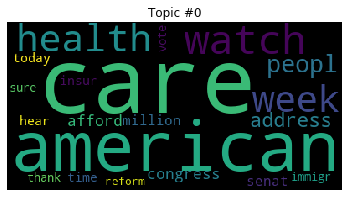

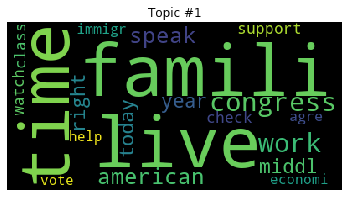

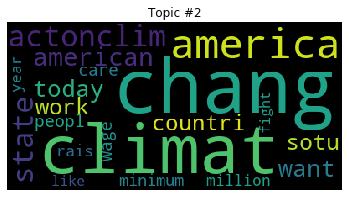

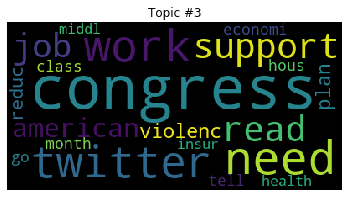

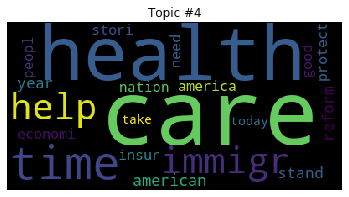

In [35]:
for topic in range(lda_model_obama.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color="black",
               max_words=20).fit_words(dict(lda_model_obama.show_topic(topic, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(topic))
    plt.show()

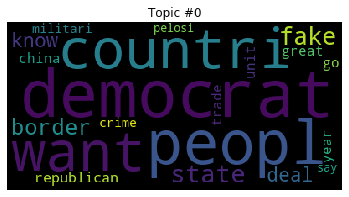

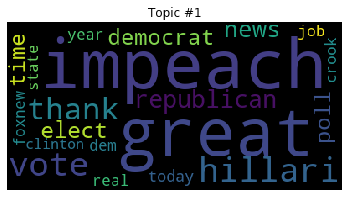

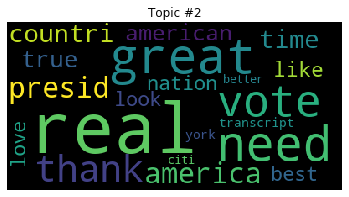

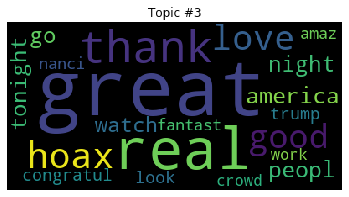

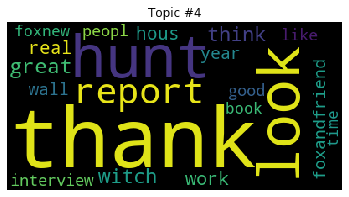

In [36]:
for topic in range(lda_model_trump.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color="black",
               max_words=20).fit_words(dict(lda_model_trump.show_topic(topic, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(topic))
    plt.show()